In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
p=3
sigma = 0.1
beta_true = [0.3, -0.1, 0.7, 0.8, 0.5, -0.4]
#beta_true = [3, -1, 7, 8, 5, -4]

In [3]:
def u(A, X, beta):
    return((1 - A) * X.dot(beta[:p]) + A * X.dot(beta[p:]))

In [4]:
def gu(A, X, beta):
    return(np.vstack(((1 - A) * X.T, A * X.T)))

In [5]:
def logit(A, X, beta):
    return(1/(1 + np.exp(-u(A, X, beta))))

In [6]:
def LinearGenerator(n=1, X=None, A=None, generate_Y=False):
    if X is None:
        X = np.random.normal(0, 1, n * (p - 1)).reshape(n, p - 1)
        X = np.hstack((np.ones(n).reshape(n, 1), X))
    else:
        X = np.asarray(X).reshape(-1, p)
        n = X.shape[0]
    if not generate_Y:
        return(X)
    elif A is not None:
        # if A not 0 or 1, raise error
        Y = u(A, X, beta_true) + np.random.normal(0, sigma, n)
        return((X, A, Y))
    else:
        Y0 = u(0, X, beta_true) + np.random.normal(0, sigma, n)
        Y1 = u(1, X, beta_true) + np.random.normal(0, sigma, n)
        Y = {'0': Y0, '1': Y1}
        return((X, A, Y))

In [7]:
def LogisticGenerator(n=1, X=None, A=None, generate_Y=False):
    if X is None:
        X = np.random.normal(0, 1, n * (p - 1)).reshape(n, p - 1)
        X = np.hstack((np.ones(n).reshape(n, 1), X))
    else:
        X = np.asarray(X).reshape(-1, p)
        n = X.shape[0]
    if not generate_Y:
        return(X)
    elif A is not None:
        # if A not 0 or 1, raise error
        # if size of A does not match X.shape[0], raise error
        Y = np.random.binomial(1, logit(A, X, beta_true))
        return((X, A, Y))
    else:
        Y0 = np.random.binomial(1, logit(0, X, beta_true))
        Y1 = np.random.binomial(1, logit(1, X, beta_true))
        Y = {'0': Y0, '1': Y1}
        return((X, A, Y))

In [8]:
def Data2O(data):
    # cannot handle len(data)=1
    X, A, Y = zip(*data)
    O = np.array(X).squeeze(), np.array(A), np.array(Y).squeeze()
    return(O)

In [9]:
def O2Data(O):
    X, A, Y = O
    # cannot handle len(Y)=1
    n = len(Y)
    data = [(X[i], A[i], Y[i]) for i in range(n)]
    return(data)

In [10]:
def MSELoss(beta, O, return_second_moment = False):
    X, A, Y = O
    n = X.shape[0]
    e = u(A, X, beta) - Y
    if not return_second_moment:
        l = np.linalg.norm(e, 2)**2/(2 * n)
        grad = np.dot(gu(A, X, beta), e)/n
        return((l, grad))
    else:
        gu_v = gu(A, X, beta)
        grad_v = gu_v * e
        Sigma = grad_v.dot(grad_v.T)/n
        Hessian = gu_v.dot(gu_v.T)/n
        return((Sigma, Hessian))

In [11]:
def CELoss(beta, O):
    X, A, Y = O
    mu = logit(A, X, beta)
    n = X.shape[0]
    l = np.mean(-Y * np.log(mu) - (1 - Y) * np.log(1 - mu))
    grad = np.dot(gu(A, X, beta), mu - Y)/n
    return((l, grad))

In [19]:
class model:
    def __init__(self, mu, generator, loss, lr, eps):
        self.mu = mu
        self.generator = generator
        self.loss = loss
        self.lr = lr
        self.eps = eps
        
    def Initialize(self):
        self.data = []
        self.beta_hat = np.zeros(2 * p)
        self.beta_bar = np.zeros(2 * p)
        self.pi_hat = 1/2
        self.step = 0
    
    def SGD(self, T, use_IPW = True):
        beta_hat_log = []
        loss_log = []
        for t in range(self.step, self.step + T):
            # observe X_t
            X = self.generator()
            # sample A_t from Bernoulli pi_hat
            A = np.random.binomial(1, self.pi_hat)
            # observe Y_t
            O = self.generator(X = X, A = A, generate_Y = True)
            # update beta_hat
            learning_rate = self.lr(t + 1)
            l, grad = self.loss(self.beta_hat, O)
            if use_IPW:
                grad *= (A/self.pi_hat + (1 - A)/(1 - self.pi_hat))/2
            self.beta_hat -= learning_rate * grad
            # update beta_bar
            self.beta_bar = (self.beta_hat + t * self.beta_bar)/(t + 1)
            # update pi_hat
            epsilon = self.eps(t + 1)
            d = int(self.mu(1, X, self.beta_bar) > self.mu(0, X, self.beta_bar))
            self.pi_hat = (1 - epsilon) * d + epsilon/2
            # log
            self.data.append(O)
            beta_hat_log.append(self.beta_hat.copy())
            loss_log.append(l)
        self.step = T
        return((loss_log, beta_hat_log))
    
    def PluginParameterVariance(self):
        beta = self.beta_hat # or beta_bar?
        # data should be a list of Os
        O = Data2O(self.data)
        
        gu_v = gu(A, X, beta)
        grad_v = gu_v * e
        Sigma = grad_v.dot(grad_v.T)/n
        Hessian = gu_v.dot(gu_v.T)/n
        return((Sigma, Hessian))
        Sigma_hat, H_hat = self.loss(beta, O, return_second_moment = True)
        H_hat_inv = np.linalg.inv(H_hat)
        V_hat = np.dot(np.dot(H_hat_inv, Sigma_hat), H_hat_inv)
        return(V_hat)

In [20]:
def lr1(t):
    return(1 * t**(-0.9))
def lr2(t):
    return(0.01 * t**(-0.9))
def lr3(t):
    return(0.01)

def eps(t):
    if t < 20:
        return(1)
    else:
        return(min(1, 0.1 * np.log(t)/np.sqrt(t)))

LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                   lr = lr1, eps = eps)
LogisticModel = model(mu = logit, generator = LogisticGenerator, loss = CELoss,
                     lr = lr3, eps = eps)

In [21]:
def MC(model, T, M):
    beta_bar = np.empty((M, 2 * p))
    beta_bar_se = np.empty((M, 2 * p))
    for i in range(M):
        model.Initialize()
        _, __ = model.SGD(T)
        V_hat = LinearModel.PluginParameterVariance()
        beta_bar[i, :] = model.beta_bar
        beta_bar_se[i, :] = np.sqrt(np.diag(V_hat))
    avg_se = np.mean(beta_bar_se, axis = 0)
    mcsd = np.std(beta_bar, axis = 0)
    ratio = avg_se/mcsd
    return(ratio)

In [22]:
MC(LinearModel, 2000, 500)

array([3.21866114, 2.56790663, 2.14953654, 3.22979149, 1.65592308,
       2.16769827])

In [25]:
V_hat = LinearModel.PluginParameterVariance()
np.sqrt(np.diag(V_hat))

array([0.52641074, 0.73641938, 0.45249515, 0.13722225, 0.12448525,
       0.12854873])

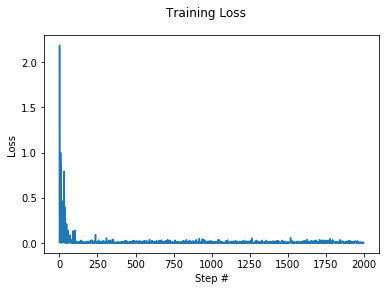

In [17]:
fig = plt.figure()
plt.plot(np.arange(0, T), loss_log)
fig.suptitle("Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()

In [12]:
beta_hat_MC = []
for m in range(1000):
    loss_log, beta_hat_log, data_log = LinearModel.SGD(T)
    beta_hat_MC.append(beta_hat - beta_true)

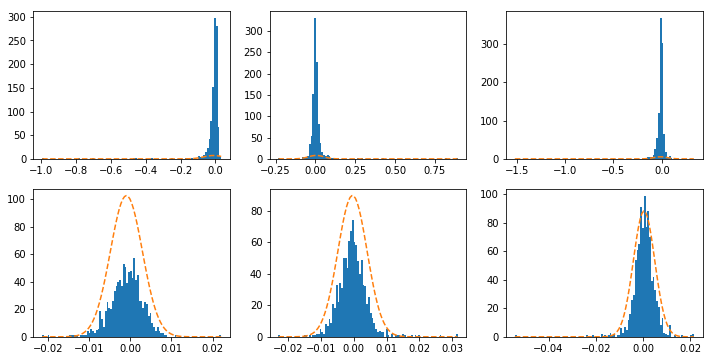

In [13]:
beta_hat_MC = np.asarray(beta_hatMC)
means = np.mean(beta_hatMC, axis=0)
sds = np.std(beta_hatMC, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_hat_MC[:,i], 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, y, '--')

In [14]:
random.seed('odm')
beta_hat_MC_sipwgd = []
for m in range(1000):
    _, beta_hat = LinearModel.SGD(T)
    beta_hat_MC_sipwgd.append(beta_hat - beta_true)

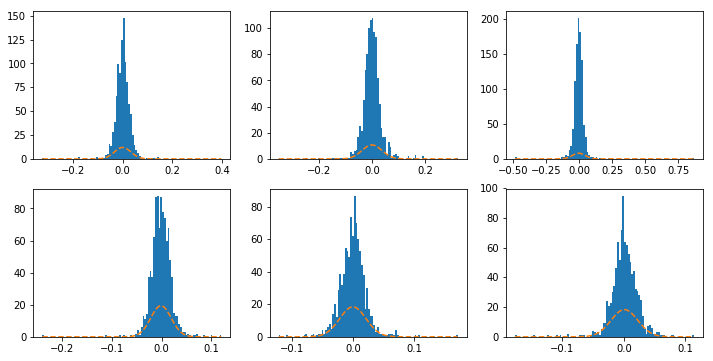

In [15]:
beta_hat_MC_sipwgd = np.asarray(beta_hat_MC_sipwgd)
means = np.mean(beta_hat_MC_sipwgd, axis=0)
sds = np.std(beta_hat_MC_sipwgd, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_hat_MC_sipwgd[:,i], 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, y, '--')

In [19]:
beta_hat_MC = []
for m in range(1000):
    _, beta_hat = LogisticModel.SGD(T)
    beta_hatMC.append(beta_hat - beta_true)

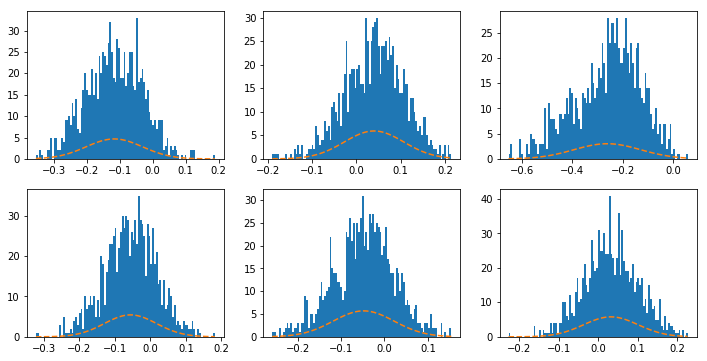

In [20]:
beta_hat_MC = np.asarray(beta_hat_MC)
means = np.mean(beta_hat_MC, axis=0)
sds = np.std(beta_hat_MC, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_hat_MC[:,i], 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, y, '--')

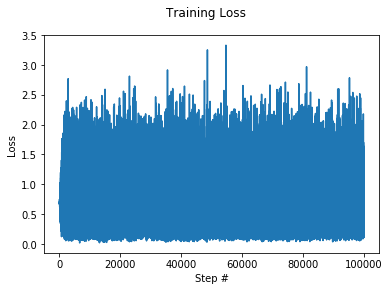

In [20]:
random.seed('chy')
T=100000

loss_log, beta_hat_log = LogisticModel.SGD(T)

fig = plt.figure()
plt.plot(np.arange(0, T), lossLog)
fig.suptitle("Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()

In [16]:
beta_hat_log

array([ 0.34903699, -0.13422294,  0.74818192,  0.82848765,  0.50994558,
       -0.33408271])

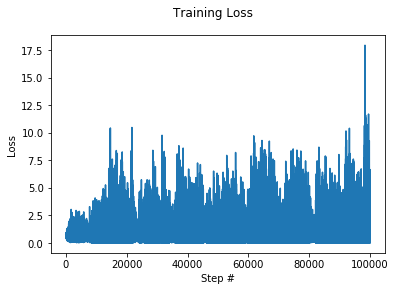

In [19]:
random.seed('chy')
T=100000

loss_log_sipwgd, beta_hat_log_sipwgd = LogisticModel.SIPWGD(T)

fig = plt.figure()
plt.plot(np.arange(0, T), loss_log_sipwgd)
fig.suptitle("Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()